C:\Users\jfsal\AppData\Local\Temp\ipykernel_17416\2534859031.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  traits_split = traits_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\jfsal\AppData\Local\Temp\ipykernel_17416\2534859031.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  traits_split = traits_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\jfsal\AppData\Local\Temp\ipykernel_17416\2534859031.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  traits_split = traits_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\jfsal\AppData\Local\Temp\ipykernel_17416\2534859031.py:54: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if not g.are_connected(unit_index, shared_unit_index):
C:\Users\jfsal\AppData\Local\Temp\ipykernel_17416\2534859031.py:25: 

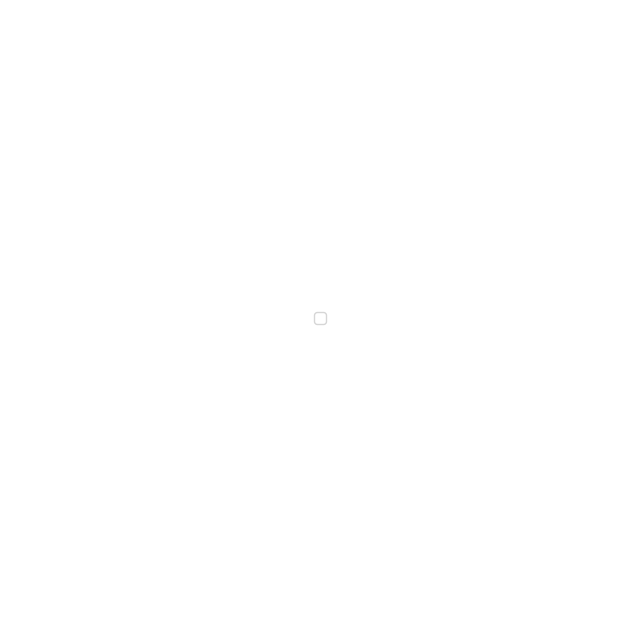

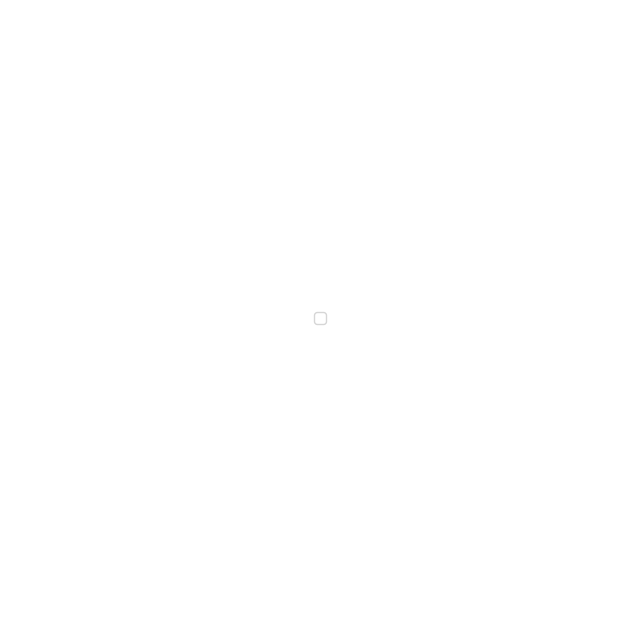

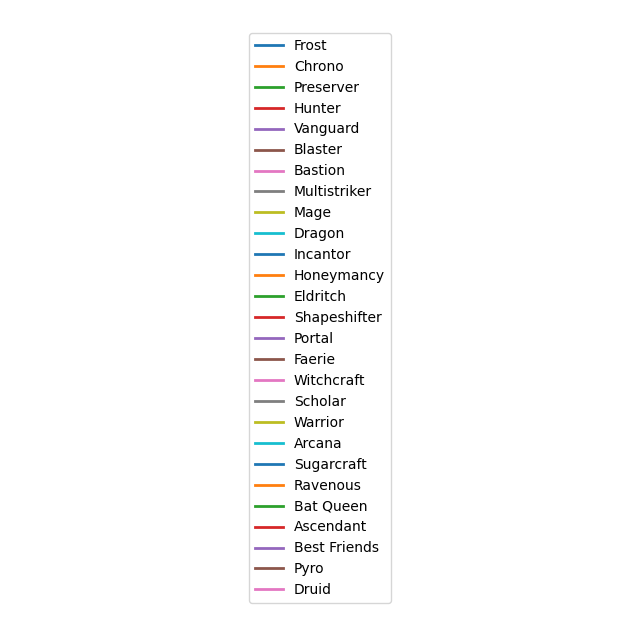

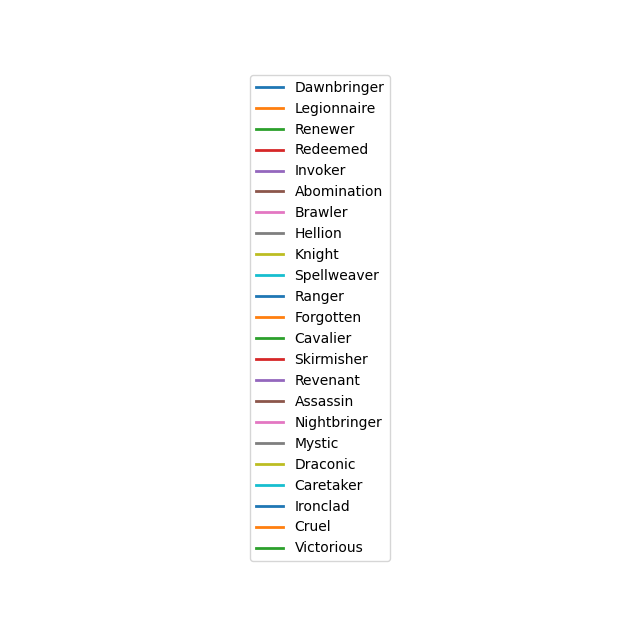

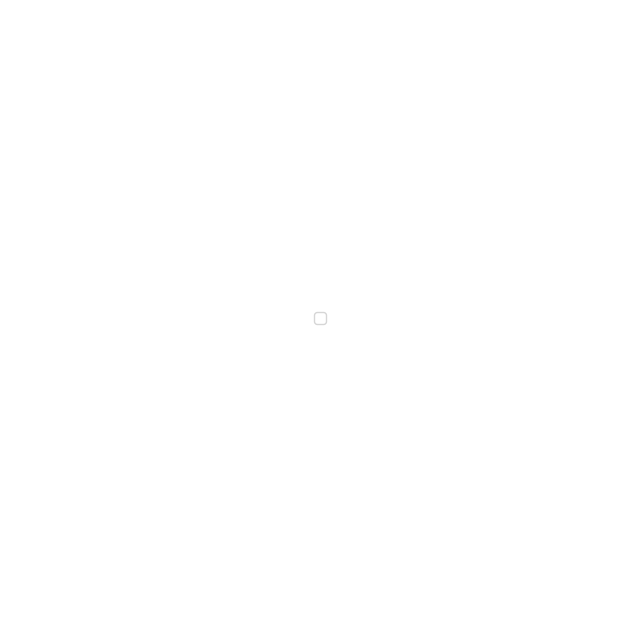

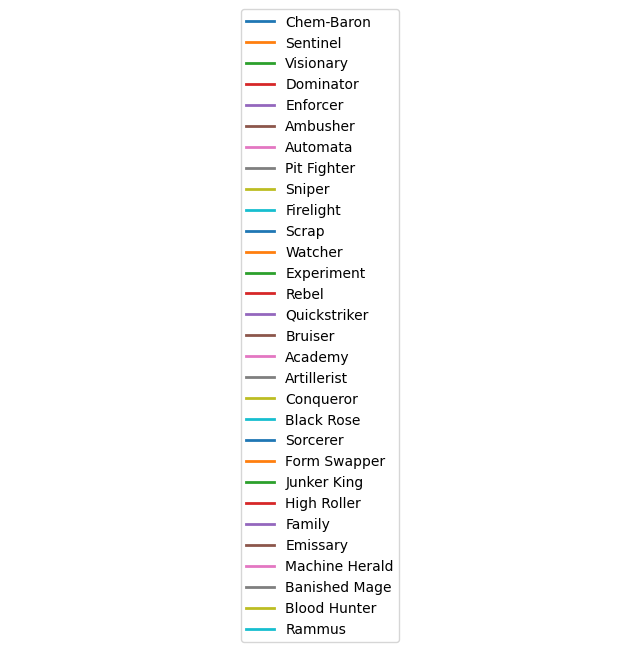

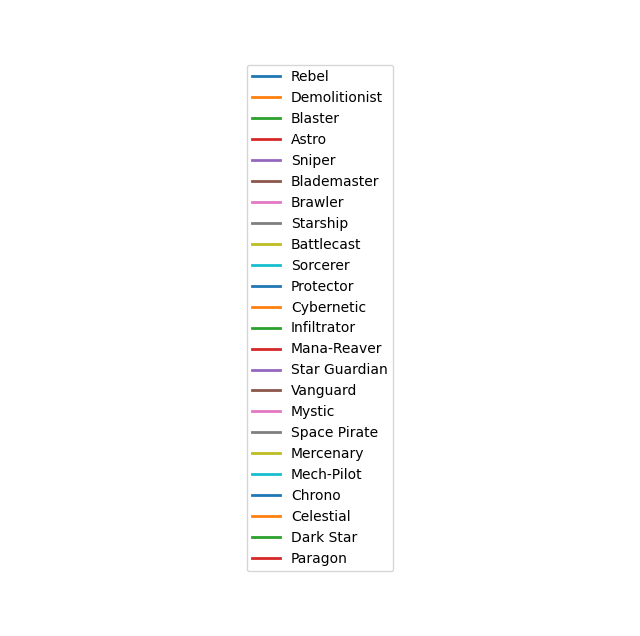

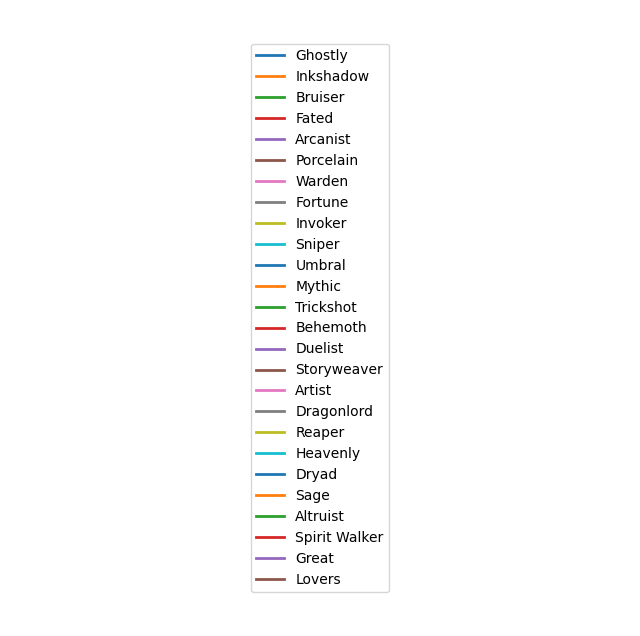

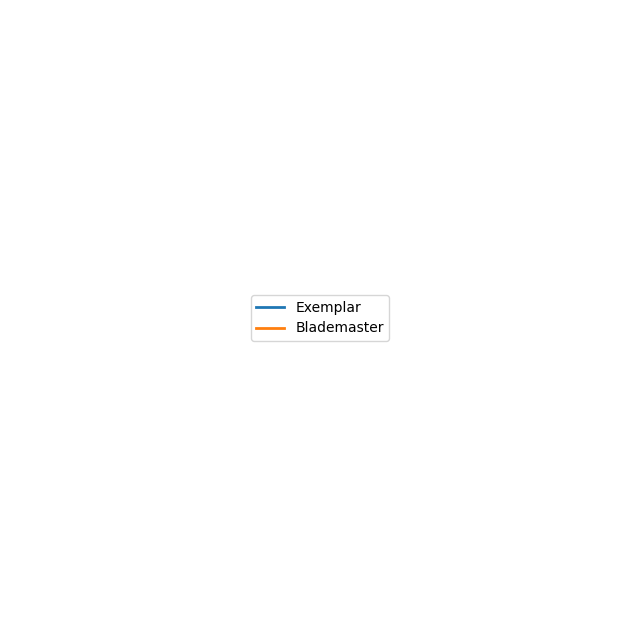

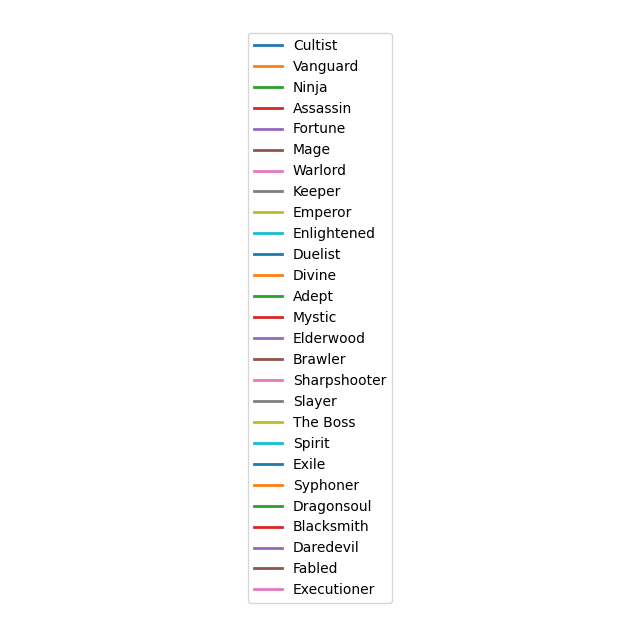

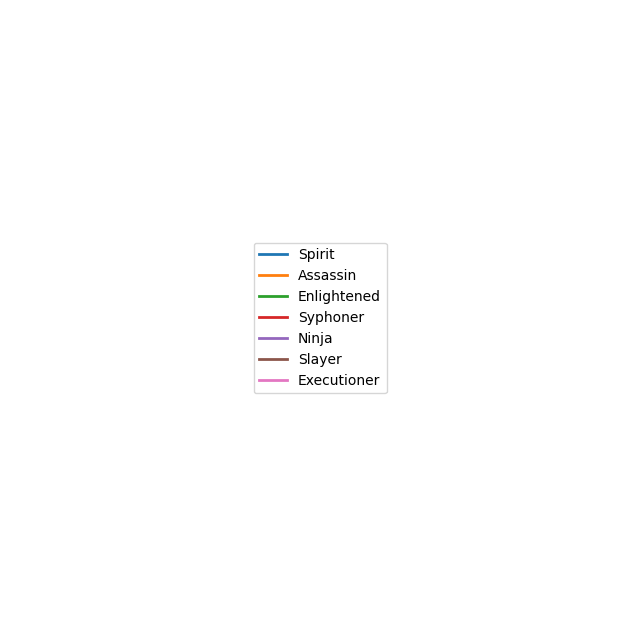

In [24]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import matplotlib.colors as mcolors
from PIL import Image
import os

#prep data
data = pd.read_csv('data/units.csv')
sets = data['set'].unique()

for set_number in sets:
    set_data = data[data['set'] == set_number]
    set_data = set_data.dropna()

    # Split traits into separate columns
    traits_split = set_data['traits'].str.split(',', expand=True)

    # Dynamically assign column names based on the maximum number of traits
    max_traits = traits_split.shape[1]
    traits_split.columns = [f'trait{i+1}' for i in range(max_traits)]

    # Strip any leading or trailing spaces from the trait names
    traits_split = traits_split.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Combine the split traits with the original data
    set_data = pd.concat([set_data, traits_split], axis=1)

    # Create a graph
    g = ig.Graph()

    # Add nodes
    units = set_data['name'].unique()
    g.add_vertices(len(units))
    g.vs['name'] = units

    # Define a color map for the traits
    colors = list(mcolors.TABLEAU_COLORS.values())
    color_map = {trait: colors[i % len(colors)] for i, trait in enumerate(set_data[[f'trait{i+1}' for i in range(max_traits)]].stack().unique())}

    # Add edges based on shared traits
    traits = set_data[['name'] + [f'trait{i+1}' for i in range(max_traits)]]
    edges = []
    edge_colors = []
    for i, row in traits.iterrows():
        unit = row['name']
        unit_index = g.vs.find(name=unit).index
        for trait in [f'trait{i+1}' for i in range(max_traits)]:
            shared_units = traits[traits[trait] == row[trait]]['name'].unique()
            for shared_unit in shared_units:
                if shared_unit != unit:
                    shared_unit_index = g.vs.find(name=shared_unit).index
                    if not g.are_connected(unit_index, shared_unit_index):
                        g.add_edge(unit_index, shared_unit_index)
                        edges.append((unit_index, shared_unit_index))
                        edge_colors.append(color_map[row[trait].strip()])  # Strip spaces when accessing the color map

    # Plot the graph
    layout = g.layout('fr')
    visual_style = {
        "vertex_label": g.vs['name'],
        "vertex_size": 20,
        "edge_width": 1,
        "edge_color": edge_colors,
        "bbox": (1600, 1600),  # Increase the size of the plot
        "margin": 40
    }
    plot_filename = f'graph_set_{set_number}.png'
    ig.plot(g, plot_filename, layout=layout, **visual_style)

    # Create a legend
    fig, ax = plt.subplots(figsize=(8, 8))
    legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=trait) for trait, color in color_map.items()]
    ax.legend(handles=legend_elements, loc='center')
    ax.axis('off')

    # Save the legend as an image
    legend_filename = f'legend_set_{set_number}.png'
    plt.savefig(legend_filename)

    # Combine the graph and the legend
    graph_img = Image.open(plot_filename)
    legend_img = Image.open(legend_filename)

    # Create a new image with space for both the graph and the legend
    combined_img = Image.new('RGB', (graph_img.width + legend_img.width, max(graph_img.height, legend_img.height)))
    combined_img.paste(graph_img, (0, 0))
    combined_img.paste(legend_img, (graph_img.width, 0))

    # Save the combined image
    combined_img.save(f'plots/set_{set_number}.png')

    # Remove the intermediate files
    os.remove(plot_filename)
    os.remove(legend_filename)

    # Display the combined image
    combined_img.show()